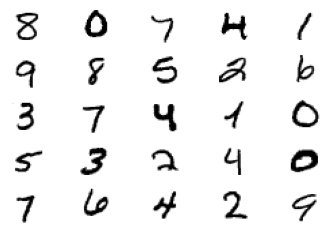

In [43]:
#In this notebook, you'll learn how to implement a Generative Adversarial Network (GAN).
#The fundamental idea behind a GAN is to have two networks - a 'generator' which creates images,
#and a 'discriminator' that tries to detect if those images are fake or real.
#We're going to use MNIST as a quick example of a GAN here, which is a database of handwritten
#numbers from 0 to 9.  We want to teach our algorithm to draw numbers.

import keras
import matplotlib.pyplot as plt
import random
import numpy as np

(trainX, trainy), (testX, testy) = keras.datasets.mnist.load_data()

#Show a few random cases:
c = 1
for i in random.sample(range(0, len(trainX)), 25):
    plt.subplot(5, 5, c)
    plt.axis('off')
    plt.imshow(trainX[i], cmap='gray_r')
    c = c + 1
plt.show()

In [44]:
#Alright!  Now we can start building our GAN.
#The first thing we want to do is build a discriminator - i.e., a network that
#can tell handwritten numbers from "fake" numbers we generate.
#This can be conceptualized as a simple CNN that is trying to predict
#a binary fake/real output.
#I'll define a simple one here.
import keras


#Note this architecture is a fairly common example that has been
#shown to work well with MNIST.  Different problems with different levels
#of complexity require more complex discriminating models.
#Note that Adam is very commonly used for GANs, as a slightly better spin
#on SGD with momentum (go back to the lecture for more details).
def discriminatingModel():
    m = keras.models.Sequential()
    m.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
    m.add(keras.layers.LeakyReLU(alpha=0.2))
    m.add(keras.layers.Dropout(0.4))
    m.add(keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    m.add(keras.layers.LeakyReLU(alpha=0.2))
    m.add(keras.layers.Dropout(0.4))
    m.add(keras.layers.Flatten())
    m.add(keras.layers.Dense(1, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    m.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return(m)

discModel = discriminatingModel()
discModel.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3136)            

In [45]:
#Next, we're going to build our generator - 
#the model we use to create our numbers.

#The first step of this is to create a "space" 
#which the model samples from to generate the numbers.
#Very simply, you can imagine a giant sphere with x,y and z
#coordinates.  If you pick a random x, y and z, an image will
#come out - in our case, a handwritten number.
#As you move around the sphere, you'll get different numbers.
#We can define that space however we want - it's normally 
#a ~100 dimension space, where you have x,y,z and 97 other dimensions
#that define each point (a hypersphere), but the best dimensions
#of this space are still a topic of inquiry.

def generateLatentSpace(nSamples, dim=100):
	#Create a location in our space to generate an image from,
    #with a unique random location for each sample we want to generate.
    sampledPoints = np.random.randn(dim * nSamples)
    #Reshape for the net.
    reshape = sampledPoints.reshape(nSamples, dim)
    return reshape

#The second step is to define the algorithm that will actually generate
#our images.  This will start at essentially generating random noise,
#and then learn over time how it can transform that noise into 
#meaningful data.
def generatorModel(dim=100):
    model = keras.models.Sequential()
	
    #We are generating 28x28 images for MNIST, through upsampling.
    #Here, we'll start with a 7x7x128 vector to represent the space,
    #and sample it to 28x28x1 at the end with a convolution.
	#Note on the input side, we start with our vector space coordinates 
    #(the 100 point vector we create with generateLatentSpace for each case).
    model.add(keras.layers.Dense(128 * 7 * 7, input_dim=dim))
	
    #Here, we're doing our earlier network (the discriminator), 
    #but backwards!  We pass our dense network outputs (128*7*7)
    #through a leaky reule, then reshape it into a 7x7x128 
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Reshape((7, 7, 128)))
	
    #Now we'll do a transposed 2D Convolution.  This is essentially a 
    #convolution in reverse - we have a filter with weights that vary,
    #and these are used to "upsample" each input pixel.  The weights get
    #fit to create more resolvable images.
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))

	#Same thing, but going up to 28,28.
    model.add(keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

genModel = generatorModel()
#Check out the output shapes here - these upscalings are happening
#based on the filter sizes and kernels across layers.
genModel.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 28, 28, 128)     

In [46]:
#Alright!  Now we have a generator and discriminator, and we need
#to tie them together.  Essentially, we're going to use this
#to back-propogate loss to our generator. 
#Pay attention to the details below, as the GAN works
#due to how backpropogation works in this component of the model.

def GAN(genModel, discModel):
	#First, we turn off the ability to update the weights in the discriminating
    #model.  We'll be training it in a seperate process; this process is just for the generator.
    discModel.trainable = False
	
    #Build our "meta" model that contains both steps.
    m = keras.models.Sequential()
	#Add our generator model here. This will generate an image based on
    #the input latent space (and weights).
    m.add(genModel)

	#And, we add the discriminator here.  This will create an estimate (1 or 0)
    #of if the image is fake or real.
    m.add(discModel)
    
    #Note that - to train our generator - we will want to *tell* this model
    #that our input images are real, even though they are all being generated by our genModel.
    #This is so that the loss function works correctly - i.e., if the discriminator says it's real,
    #then we're happy (because our generator fooled it).  So, when we go to train the generator,
    #we'll need to label some of our fake cases as real cases in the Y we pass.
    opt = keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
    m.compile(loss='binary_crossentropy', optimizer=opt)
    return(m)

ganModel = GAN(genModel, discModel)
ganModel.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_19 (Sequential)   (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [47]:
#Here, we're going to write three data loaders.
#The first will load our real samples, and rescale them for input into our network.
#(Remember, we need 28,28,1).  The second will generate samples from that data.
#And, the third will generate fake samples using our generator.
import numpy as np

#Load our Real Data:
def loadData():
    (trainX, _), (_, _) = keras.datasets.mnist.load_data()
    #Add a dimension to the data - we need 28,28,1
    X = np.expand_dims(trainX, axis=-1)

    #Next, we're going to convert from integers to floats.
    #Ultimately we want data scaled between 0 and 1 for input into our net.
    X = X.astype('float32')

    #Now we scale - our image data is from 0 to 255 in it's raw form.
    X = X / 255.0

    return(X)

#Generate Samples from our Data:
def generateRealSamples(dta, nSamples):
    #Choose random indices from our input data
    rnd = np.random.randint(0, dta.shape[0], nSamples)
    #Select them
    X = dta[rnd]
    #General class labels (1 for "real" images)
    y = np.ones((nSamples, 1))

    return(X,y)

def generateFakeSamples(genModel, nSamples, dim=100):
    #First, we sample our latent space to grab a 100-element (dim element)
    #vector, representing a "spot" in that space.
    inputData = generateLatentSpace(dim=dim, nSamples=nSamples)

    #Now, we predict the output at that space
    X = genModel.predict(inputData)

    #Generate class labels (0 for fake)
    y = np.zeros((nSamples, 1))

    return(X,y)


#We're also going to add a helper function here for visualization and output

def saveResults(genModel, epoch, dim=100, size=5):
    #Generate a few fake samples
    fakeImages, _ = generateFakeSamples(genModel, dim=dim, nSamples=size*size)

    #Visualize and save the results
    for i in range (size*size):
        plt.subplot(size, size, 1+i)
        plt.axis('off')
        #Inverse the colors to make it match
        plt.imshow(fakeImages[i,:,:,0], cmap="gray_r")
    outFile = "./mnistGen/epoch_" + str(epoch) + ".png"
    plt.savefig(outFile)
    plt.close()




In [ ]:
#Ok!  Now we have all the pieces we need - time to string them together in a training function.
#This is the big function that will actually train our data.

def train(genModel, discModel, ganModel, dta, dim=100, epochs=20, batchSize=1024):
    #Calculate the number of batches required to complete an epoch
    #(until all data is seen by the model)
    totalBatches = int(dta.shape[0] / batchSize)

    #Iterate over each epoch / batch
    for i in range(epochs):
        print("Starting Epoch " + str(i))
        for j in range(totalBatches):
            print("       Batch " + str(j))
            #First, we generate a set of real samples
            xReal, yReal = generateRealSamples(dta, batchSize)

            #Second, we generate our fake examples.
            xFake, yFake = generateFakeSamples(genModel, nSamples = batchSize, dim=100)

            #We stack these together to train our discriminating model
            X, y = np.vstack((xReal, xFake)), np.vstack((yReal, yFake))

            #Use this to train our discriminator and update weights.
            #This shoudl be intuitive - each step, our discriminator learns to 
            #tell the difference between fake and real data, and we tell it what
            #is fake and real so it gets good at it!
            discLoss, _ = discModel.train_on_batch(X,y)

            #Now we need to update the generator, which is trickier.
            #First we need our latent points we use to initialize
            inputSample = generateLatentSpace(nSamples=batchSize, dim=100)

            #Remember - we're going to tell the GAN trainer that our fake
            #data is actually true data, so that when it labels them all as true,
            #we know that we've fooled it (i.e., there would be no loss).
            #If it labels them all as false, we get maximum loss, because we
            #haven't fooled it.
            inputY = np.ones((batchSize, 1))

            #Actually train the generator via the GAN
            #(Remember, the discriminating model is frozen here)
            ganLoss = ganModel.train_on_batch(inputSample, inputY)

        #Finally, every epoch we'll save the ouputs.
        saveResults(genModel, i)

#And, now we just call the model
#Note you may need to do a %reset to clear past model states, if you run this cell more than once
#on jupyter.
#%reset
train(genModel, discModel, ganModel, dta=loadData(), dim=100, epochs=100, batchSize=256)